# Mask R-CNN Demo

### Environment Setup

In [122]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imgaug
from imgaug import augmenters as iaa

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.whales import whale

import numpy.ma as ma
import scipy.misc

import numpy as np
import matplotlib.pyplot as plt
import skimage.filters

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

### Model and dataset setup

In [123]:
#sets up the system and generates masks
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
%matplotlib inline 

# Path to trained weights
#WHALE_WEIGHTS_PATH = "/home/clifgray/Code/Mask_RCNN/logs/whale20180613T0247/mask_rcnn_whale_0075.h5"

config = whale.WhaleConfig()
WHALE_DIR = os.path.join(ROOT_DIR, "datasets/whale_training/blue")
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
# Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
#config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

# Load validation dataset
dataset = whale.WhaleDataset()
dataset.load_whale(WHALE_DIR, "test")
#
# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))


#Getting manually drawn masks
id_array = np.arange(len(dataset.image_ids)) #17 images in this set
mask_array = []
for num in id_array:
    image_id = num

    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]
   # if image_id >= 19 and image_id <= 35:
    mask_array.append(mask)


Images: 17
Classes: ['BG', 'Balaenoptera_musculus_body', 'Balaenoptera_musculus_pectoral']


In [124]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Function for Whale Masking

In [4]:
def run_cnn(weights_path="/home/clifgray/Code/Mask_RCNN/logs/whale20180613T0247/mask_rcnn_whale_0150.h5"):
    # Create model in inference mode
    with tf.device(DEVICE):
        model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
        
    # Load weights
    print("Loading weights ", weights_path)
    model.load_weights(weights_path, by_name=True)
    print("Weights loaded.")
    
    
    detection_results = []
    initial_time = time.perf_counter()
    for image_id in dataset.image_ids:
    
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

        info = dataset.image_info[image_id]

        # Run object detection
        results = model.detect([image], verbose=0)
        
        detection_results.append([results, info, image_id])
        print("Done detecting and masking image #:  " + str(len(detection_results)))
    
    finish_time = time.perf_counter()
    time_elapsed = finish_time - initial_time
    print("\n")
    print(time_elapsed, "seconds elapsed while masking", len(detection_results), "images.")
    print((time_elapsed/len(detection_results), "seconds per image."))
    
    return detection_results



### Run detection and masking

In [5]:
detection_results = run_cnn()

Loading weights  /home/clifgray/Code/Mask_RCNN/logs/whale20180613T0247/mask_rcnn_whale_0150.h5
Weights loaded.
Done detecting and masking image #:  1
Done detecting and masking image #:  2
Done detecting and masking image #:  3
Done detecting and masking image #:  4
Done detecting and masking image #:  5
Done detecting and masking image #:  6
Done detecting and masking image #:  7
Done detecting and masking image #:  8
Done detecting and masking image #:  9
Done detecting and masking image #:  10
Done detecting and masking image #:  11
Done detecting and masking image #:  12
Done detecting and masking image #:  13
Done detecting and masking image #:  14
Done detecting and masking image #:  15
Done detecting and masking image #:  16
Done detecting and masking image #:  17


55.69309554199572 seconds elapsed while masking 17 images.
(3.2760644436468067, 'seconds per image.')


### Look at an example mask

image ID: whale.DSC04110.JPG (9) /home/clifgray/Code/Mask_RCNN/datasets/whale_training/blue/test/DSC04110.JPG
gt_class_id              shape: (3,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (3, 4)                min:  225.00000  max:  785.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool


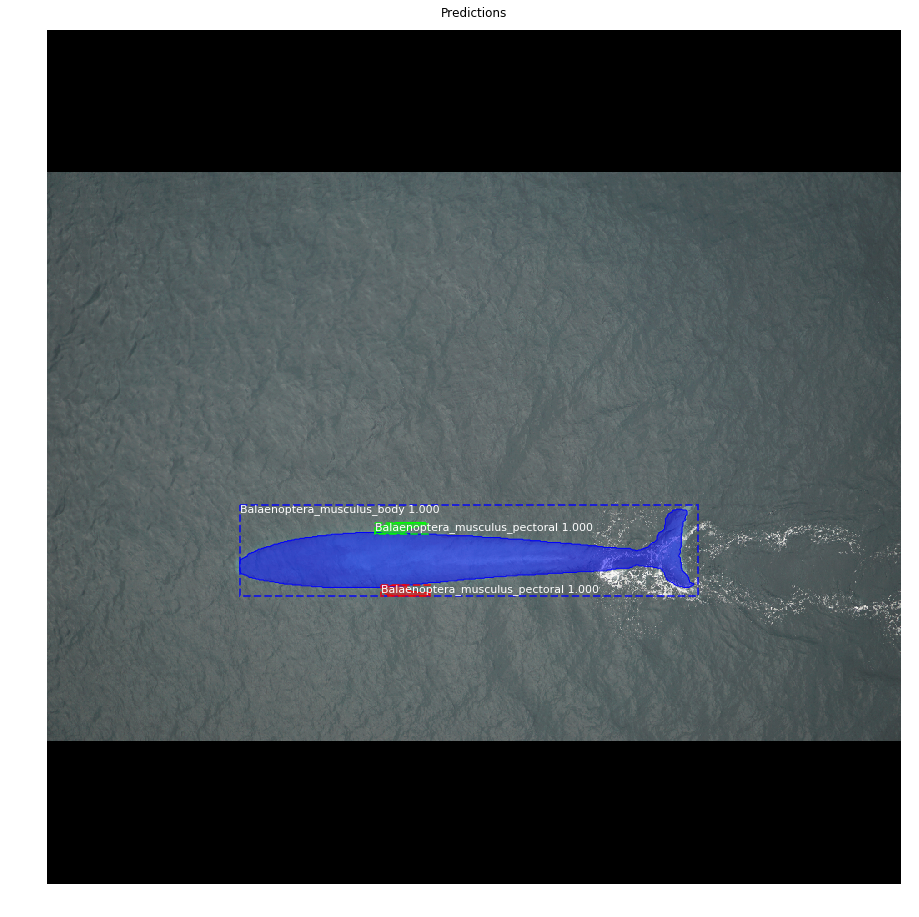

In [132]:
results_object = detection_results[9]
image_id = results_object[2]
info = results_object[1]

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

results = results_object[0]

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Measuring from the Mask

In [7]:
#After run through NN, each image could have multiple masks
def find_correct_mask(mask): 
    #Find which mask to use - one with the largest number of pixels
    numOfMasks = np.size(mask, 2)
    i = 0
    pixcount = 0
    pixCountArray = []
    while i < numOfMasks:
        currentMask = (mask[:, :, i])
        pixcount = 0
        nonzero = np.nonzero(currentMask)
        it2 = np.nditer(currentMask, flags =['multi_index'])
        while not it2.finished:
            if it2[0] == True:
                pixcount = pixcount + 1
            it2.iternext()
        pixCountArray.append(pixcount)
        i = i+1

#Find max in pixCountArray - gets the biggest mask that will be the body
    correctIndex = pixCountArray.index(max(pixCountArray))
    body = (mask[:,:,correctIndex])
    return body

In [143]:
def pca(body, boolean):
    xy_array = []
 # get indexes of mask pixels
    y, x = np.nonzero(body)
    
# mean center the coords
    x = x - np.mean(x)
    y = y - np.mean(y)
    coords = np.vstack([x, y])

# build covariance matreix and eigenvectors
    cov = np.cov(coords)
    evals, evecs = np.linalg.eig(cov)
    
# sort eigenvalues
    sort_indices = np.argsort(evals)[::-1]
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, sort_indices[1]]

    
    if boolean == True:
# plot the major and minor axis of the whale mask
        scale = 20
        plt.plot(x, y, 'k.')

        plt.plot([x_v1*-scale*2, x_v1*scale*2],
         [y_v1*-scale*2, y_v1*scale*2], color='red')
        plt.plot([x_v2*-scale, x_v2*scale],
         [y_v2*-scale, y_v2*scale], color='blue')
        plt.axis('equal')
        plt.gca().invert_yaxis()  # Match the image system with origin at top left
        plt.show()

# orient this along the horizontal axis
    theta = np.tanh((x_v2)/(y_v2))  
    rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
    transformed_mat = rotation_mat * coords
# plot the transformed blob
#these are the final transformed coords
    x_transformed, y_transformed = transformed_mat.A

    maxX = np.max(x_transformed)
    minX = np.min(x_transformed)
    maxY = np.max(y_transformed)
    minY = np.min(y_transformed)


#Get corresonding Y values for minX and maxX
    maxX_index = np.where(x_transformed == maxX) #index of right-most point
    rightY = float((y_transformed[maxX_index])) #corresponding Y value


    minX_index = np.where(x_transformed == minX) #index of left-most point
    leftY = float((y_transformed[minX_index])) #corresponding Y value
    
#Orient the mask correctly - flip so the fluke is on the right

#Get corresonding X values for maxY and minY

    maxY_index = np.where(y_transformed == maxY) #index of top point
    topX = float((x_transformed[maxY_index])) #corresponding X value


    minY_index = np.where(y_transformed == minY) #index of bottom point
    bottomX = float((x_transformed[minY_index])) #corresponding X value

    #Flip mask so fluke is on the right, if necessary
    if (topX < 0 or bottomX < 0):
        x_transformed = x_transformed*-1 
    
    xy_array = [x_transformed, y_transformed]
    
    return xy_array


In [133]:
def measure(results_list):
    length_list = []

    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    
    for item in results_list:
        if np.array_equal(results_list, detection_results):
            mask = item[0][0]["masks"]
        else:
            mask = item 
        body = find_correct_mask(mask)
        xy_array = pca(body, False)
        x_transformed = xy_array[0]
        y_transformed = xy_array[1]
        
        #Reassign max/min X values in case image was flipped during PCA

        maxX = np.max(x_transformed) #rightX
        minX = np.min(x_transformed) #leftX

#Get corresonding Y values for leftX and rightX

        maxX_index = np.where(x_transformed == maxX) #index of right-most point
        rightY = float((y_transformed[maxX_index])) #corresponding Y value


        minX_index = np.where(x_transformed == minX) #index of left-most point
        leftY = float((y_transformed[minX_index])) #corresponding Y value
        
#Get points from leftX and rightX until it runs off the mask

#Filter out points above straight line 
#Arbitrary lambda, might need to change later
        lowEnough = list(filter(lambda y: y < (leftY + 0.5), y_transformed))
        yValues = list(filter(lambda y: y > (leftY - 0.5), lowEnough)) 
        yValues.sort()

#Get corresponding X values
#List of appropriate indices
        indices = []
        for point in yValues:
            index = int(np.where(y_transformed == point)[0])
            indices.append(index)
    
        xValues = [] #Corresponding X values
        for index in indices:
            xValues.append(x_transformed[index]) 

        xValues.sort()


        length = math.sqrt((xValues[-1] - xValues[0])**2 + (yValues[-1] - yValues[0])**2)
        length_list.append(length)
        if np.array_equal(results_list, detection_results):
            item.append(length)
        
        
      
    return length_list
    

In [134]:
cnn_length_list = measure(detection_results)
manual_mask_lengths = measure(mask_array)

In [42]:
excel_measurements = pd.read_excel("NSF-IOS_2017Measurements_kcb_updated_062018.xlsx")
blue_measurements = excel_measurements.loc[excel_measurements["Whale"].str.contains("Bm")]
blue_measurements = blue_measurements.reset_index(drop=True)

# imaged were downsized from 6000 as a max dimension to 1024 as a max dimension so pixels are 5x as large in meters
pixel_size_factor = 6000.0 / 1024.0

measurements_df = pd.DataFrame(np.nan, index=np.arange(0, len(blue_measurements)), columns=['Filename', 'Auto_Measurement', 'Manual_Measurement', 'Estimated_Manual_Error'])

measurements_df.set_index("Filename")

for index, row in blue_measurements.iterrows():
    cnn_pixel_count = 0
    percent_error = 0
    manual_pixel_count = 0
    
    for whale in detection_results: #CNN Masks
        if whale[1]['id'] == (row['Image']):
            cnn_pixel_count = whale[3]
            
        adjusted_cnn_pixel_count = cnn_pixel_count * pixel_size_factor
            
    for length in manual_mask_lengths: #Manual Masks
        manual_pixel_count = length
        adjusted_manual_pixel_count = manual_pixel_count * pixel_size_factor
    
    total_altitude = row["Total Altitude"]
    pixel_size = row["Pixel size"]
    focal_length = row["Focal length (mm)"] #always 5
    
  
    
        
    measurements_df.loc[measurements_df.index[index], "Filename"] = row["Image"]
    measurements_df.loc[measurements_df.index[index], "Auto_CNN_Measurements"] = adjusted_cnn_pixel_count * pixel_size/focal_length * total_altitude
    measurements_df.loc[measurements_df.index[index], "Manual_Mask_Measurements"] = adjusted_manual_pixel_count * pixel_size/focal_length * total_altitude
    measurements_df.loc[measurements_df.index[index], "Manual_Standard_Measurements"] = row["Total Length (m)"]
    
    measurements_df.loc[measurements_df.index[index], "Estimated_Manual_Error"] = row["Estimated % Error"]
    
    # Percent error
    #percent_error = abs(measurements_df["Auto_CNN_Measurement"][index] - measurements_df["Manual_Standard_Measurement"][index])/measurements_df["Manual_Standard_Measurement"][index]*100
    #measurements_df.loc[measurements_df.index[index], "Auto_Percent_Error"] = percent_error

measurements_df

,Filename,Auto_Measurement,Manual_Measurement,Estimated_Manual_Error,Auto_CNN_Measurements,Manual_Mask_Measurements,Manual_Standard_Measurements
0,DSC02689.JPG,NaN,NaN,0.0004,21.804893,19.311632,22.528405
1,DSC03182.JPG,NaN,NaN,0.0074,20.033111,23.410923,20.304210
2,DSC03206.JPG,NaN,NaN,0.0074,21.853873,19.942070,22.358987
3,DSC03331.JPG,NaN,NaN,0.0074,21.965600,19.990342,22.456202
4,DSC03665.JPG,NaN,NaN,0.0004,21.527112,20.494306,22.139630
5,DSC03795.JPG,NaN,NaN,0.0004,21.168680,20.336080,21.639458
6,DSC03868.JPG,NaN,NaN,0.0004,22.123516,16.525244,22.547801
7,DSC03996.JPG,NaN,NaN,0.0074,20.620096,22.421875,21.056910
8,DSC04067.JPG,NaN,NaN,0.0074,22.537984,23.583094,22.929705
9,DSC04110.JPG,NaN,NaN,0.0074,21.053401,23.290778,21.357748


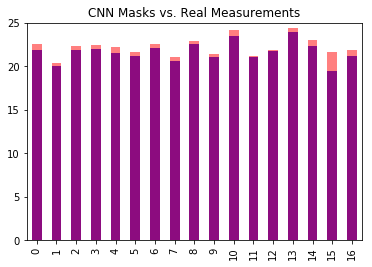

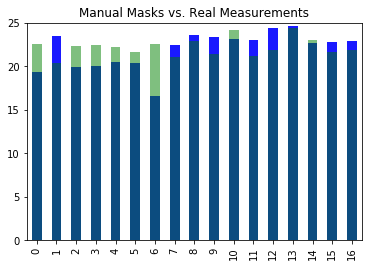

In [90]:
# Histograms comparing lengths

plt.figure()
plt.ylim(0, 25)
measurements_df["Auto_CNN_Measurements"].plot.bar(stacked = True, alpha = 0.9, color = 'b', title = "CNN Masks vs. Real Measurements")
measurements_df["Manual_Standard_Measurements"].plot.bar(stacked = True, alpha = 0.5, color = "r")


plt.figure()
plt.ylim(0, 25)
measurements_df["Manual_Mask_Measurements"].plot.bar(stacked = True, alpha = 0.9, color = 'b', title="Manual Masks vs. Real Measurements")
measurements_df["Manual_Standard_Measurements"].plot.bar(stacked = True, alpha = 0.5, color = "g")



In [139]:
def show_example(whale_list, index):
    
    image_id = index
    
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False)
    log("molded_image", image)
    log("mask", mask)
    print("mask.shape", mask.shape)

    visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, show_bbox=False)
    

    # All copied from measure()
    length_list = []

    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    
    item = whale_list[index]
    if np.array_equal(whale_list, detection_results):
        mask = item[0][0]["masks"]
        print("inside if")
    else:
        mask = item 
    body = find_correct_mask(mask)
    xy_array = pca(body, True)
    x_transformed = xy_array[0]
    y_transformed = xy_array[1]
        #Reassign max/min X values in case image was flipped

    maxX = np.max(x_transformed) #rightX
    minX = np.min(x_transformed) #leftX
    print(image_id)
#Get corresonding Y values for leftX and rightX

    maxX_index = np.where(x_transformed == maxX) #index of right-most point
    rightY = float((y_transformed[maxX_index])) #corresponding Y value


    minX_index = np.where(x_transformed == minX) #index of left-most point
    leftY = float((y_transformed[minX_index])) #corresponding Y value

#Filter out points above straight line 
#Arbitrary lambda, might need to change later
    lowEnough = list(filter(lambda y: y < (leftY + 0.5), y_transformed))
    yValues = list(filter(lambda y: y > (leftY - 0.5), lowEnough)) 
    yValues.sort()

#Get corresponding X values
#List of appropriate indices
    indices = []
    for point in yValues:
        index = int(np.where(y_transformed == point)[0])
        indices.append(index)
    
    xValues = [] #Corresponding X values
    for index in indices:
        xValues.append(x_transformed[index]) 

    xValues.sort()

#Plot the first and last points from the list, use this for length
    plt.scatter(xValues[0], yValues[0])
    plt.scatter(xValues[-1], yValues[-1])


    length = math.sqrt((xValues[-1] - xValues[0])**2 + (yValues[-1] - yValues[0])**2)
    length_list.append(length)
        
    if np.array_equal(whale_list, detection_results):
        item.append(length)
        
    plt.xlim([minX - 100, maxX + 100])
    plt.ylim([leftY - 200, rightY + 200])

        #plt.plot(x_transformed, y_transformed, alpha = 0.5)
    plt.plot(x_transformed, y_transformed, 'g.')
    plt.show()
        
    # Change to real world values
    adjusted = length * pixel_size_factor
    meters = (adjusted)* pixel_size/focal_length * total_altitude
      
    print("Length in Pixels", length)
    print("Length in Meters", meters)
    return length_list
    

molded_image             shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
mask                     shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool
mask.shape (1024, 1024, 3)


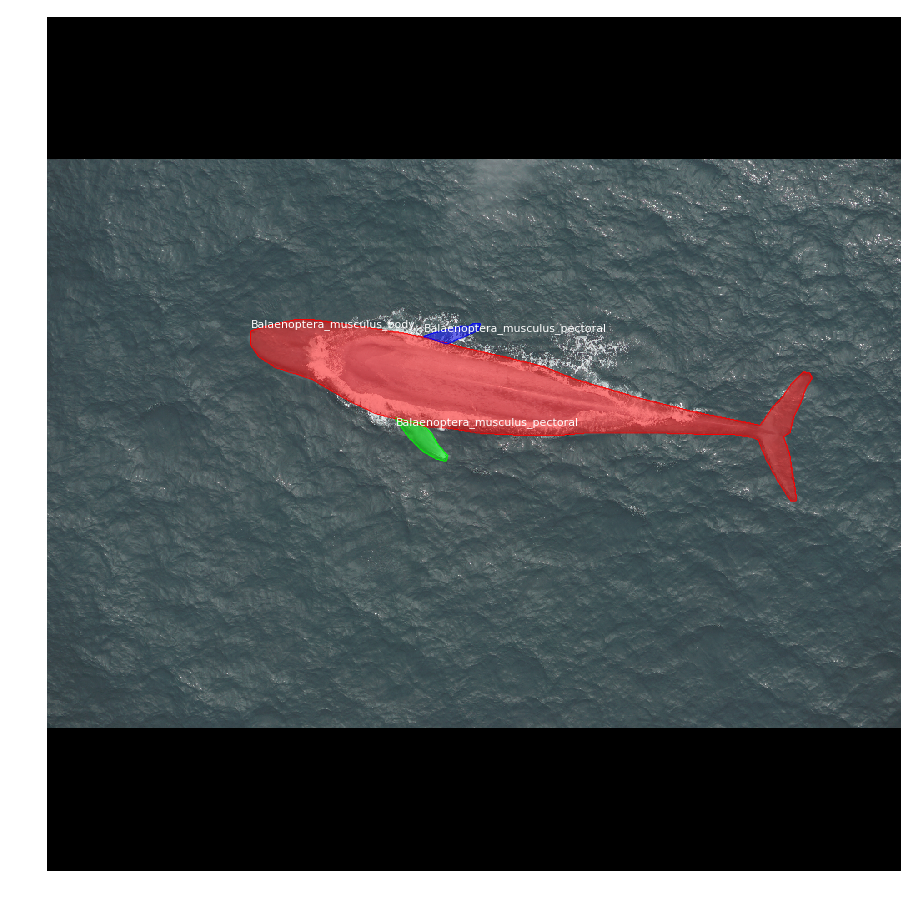

inside if


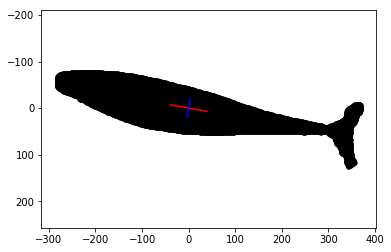

3


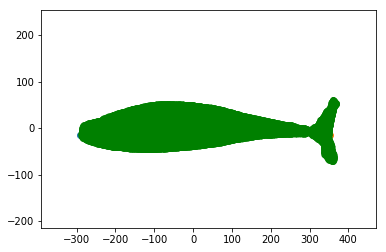

Length in Pixels 642.023252025409
Length in Meters 25.12950866819744


[642.023252025409]

In [144]:
show_example(detection_results, 3)

molded_image             shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
mask                     shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool
mask.shape (1024, 1024, 3)


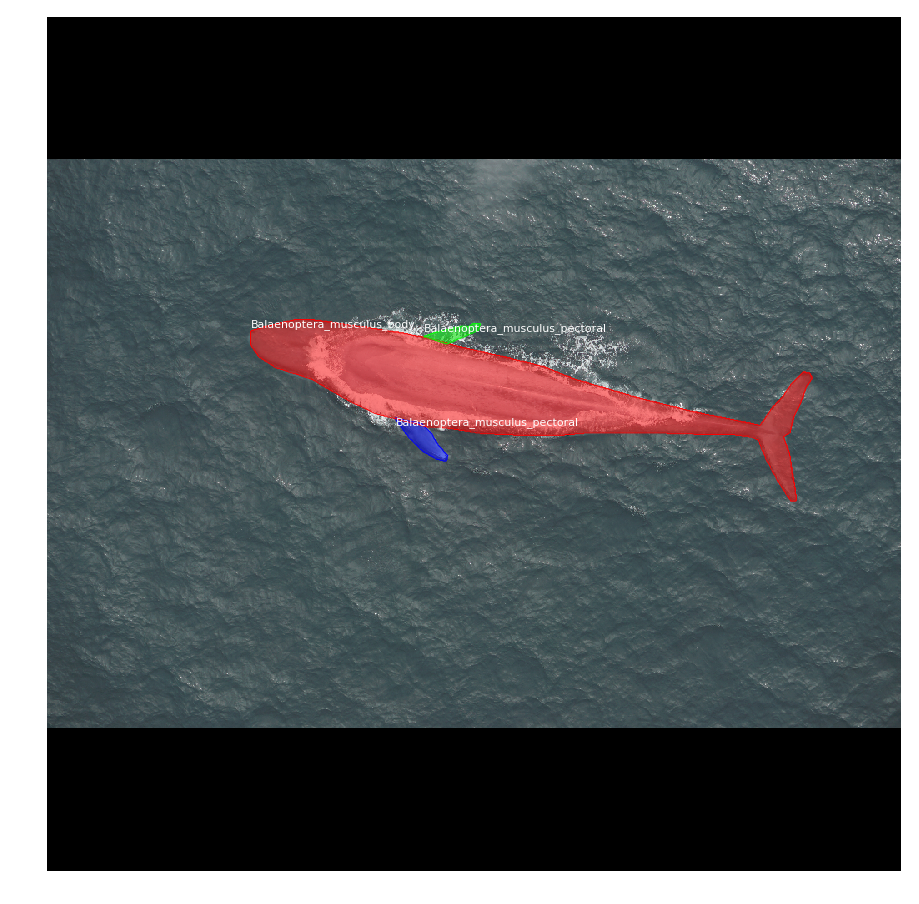

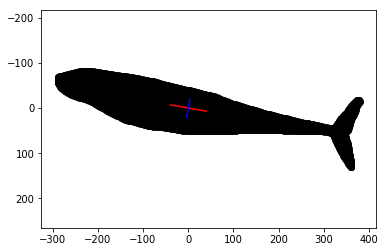

3


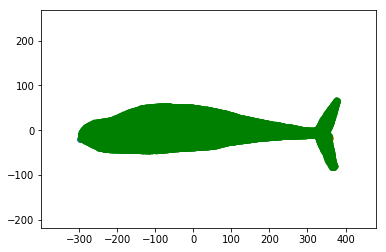

Length in Pixels 657.9520612994761
Length in Meters 25.752980091489274


[657.9520612994761]

In [145]:
show_example(mask_array, 3)